# txt format EMG reading using NeuroKit - failure which motivate us to develop NeuroKit2
# NeuroKit2 is under construction - see more in Github.ganshengT


In [92]:
# import emg and select one channel
import pandas as pd
import numpy
import cvxopt
import neurokit as nk

emg_data = pd.read_csv('D:/Data/EMGsample/yzt_1108.txt', header = None,skiprows=8, 
                       sep = '\t',usecols=[0,1,2,3,4,5],skipfooter=1,engine = 'python')
emg_data = emg_data.loc[:,[2]].rename({2: 'EMG'},axis=1)
emg_data

bio = nk.bio_process(emg=emg_data['EMG'],sampling_rate=100, emg_envelope_freqs=None, emg_envelope_lfreq=None,emg_activation_treshold=0.01,
                     emg_activation_n_above=0.25, emg_activation_n_below=0.5)
#emg_data.loc[:,[1,2,3]].plot()

,EMG
0,0.0180
1,0.0165
2,0.0142
3,0.0165
4,0.0165
...,...
330170,0.0135
330171,0.0135
330172,0.0135
330173,0.0135


# Two more data structure remain to be decided
- EMG position

# Instable factors
- Data alignment of EMG and EEG - sol: pre-processing in Mne
- incorrect type of last event_id of eeg .set file 
- No ERP for EMG analysis epochs_emg.plot_image(picks='emg') reason: in plot_image if ch_type in _DATA_CH_TYPES_SPLIT}

In [9]:
# MNE create object use array

##################### read EMG into framework ##################### 
import mne 
import pandas as pd
import numpy as np
# import pixiedust
ch_types = ['emg', 'emg']
ch_names = ['emg2', 'emg3']
emg_data = pd.read_csv('D:/Data/EMGsample/yzt_1108.txt', header = None,skiprows=8, 
                       sep = '\t',usecols=[0,1,2,3,4,5],skipfooter=1,engine = 'python')
# emg_data = np.array([emg_data.loc[:,[2,3]].rename({2: 'EMG2'},axis=1),emg_data.loc[:,[2]].rename({3: 'EMG3'},axis=1)])
sfreq = 100
# emg_data.loc[:,[2,3]].to_numpy()
emg_data = emg_data.loc[:,[2,3]].T
#emg_montage = mne.channels.read_montage('txt', path=r'D:\Data\montage\emg_test', unit='m', transform=False)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw_emg = mne.io.RawArray(emg_data, info)


########### read eeg set data, its montage and resample EEG to 100Hz ####################
eeg_fname = 'D:/Data/CMC11Nov/czf11Nov.set'
epochs_eeg = mne.io.read_epochs_eeglab(eeg_fname)
epochs_eeg.set_montage('standard_1020')
epochs_eeg_resampled = epochs_eeg.copy().resample(100, npad='auto')

### EMG Rvent engineering ###
# annotation editing, code of begining of each trial '2' # - '2' is a string
num_trials = 55
trials_interval = 12
annotations_df = pd.DataFrame()
onsets = np.array([trials_interval*i+1 for i in range(num_trials)])
durations = np.repeat(0, num_trials) # the begining of each trial does not represent specified event block
descriptions = ['2']*num_trials
annot_emg = mne.Annotations(onsets,durations,descriptions)
raw_emg.set_annotations(annot_emg)
events,events_code_dict = mne.events_from_annotations(raw_emg)


# #Alternative
# duration = 12
# event_id =1
# events = mne.make_fixed_length_events(raw_emg, event_id,duration = duration)
# tmin = 0.
# tmax = 0.99
# epochs_emg = mne.Epochs(raw_emg,events=events, event_id = event_id,tmin = tmin, tmax = tmax,baseline = None, verbose = True)
# epochs_emg.plot(block = True,picks = "emg")


################## Not correct - to mitigate the effect of pruning, I use 11.99, SHOULD SOLVE IN EEGLAB #######################
epochs_emg = mne.Epochs(raw_emg,events,events_code_dict['2'],tmin = 0, tmax = 11.989,baseline=(0, 0),preload=True) 
# epochs_emg.plot(block = True,picks = "emg")
###################################################################################################

epochs_eeg_resampled.add_channels([epochs_emg])

Creating RawArray with float64 data, n_channels=2, n_times=330175
    Range : 0 ... 330174 =      0.000 ...  3301.740 secs
Ready.
Extracting parameters from D:/Data/CMC11Nov/czf11Nov.set...
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
DigMontage is a superset of info. 62 in DigMontage will be ignored. The ignored channels are: {'M1', 'PO2', 'C5', 'FCz', 'C6', 'AF5', 'CP3', 'TP7', 'POz', 'C2', 'CPz', 'PO6', 'PO10', 'FT9', 'PO1', 'T10', 'FC4', 'AF2', 'F5', 'CP4', 'T3', 'P5', 'F2', 'AF8', 'PO8', 'P10', 'FT8', 'Fpz', 'PO5', 'TP8', 'TP10', 'F1', 'O9', 'T5', 'P9', 'FT7', 'TP9', 'P1', 'AF7', 'AF9', 'F6', 'T6', 'Iz', 'P6', 'A2', 'FT10', 'M2', 'T4', 'C1', 'P2', 'AF1', 'O10', 'PO9', 'F9', 'AF10', 'FC3', 'AFz', 'PO7', 'AF6', 'A1', 'T9', 'F10'}


<ipython-input-9-a86c99aef337>:23: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs_eeg = mne.io.read_epochs_eeglab(eeg_fname)


Used Annotations descriptions: ['2']
55 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 55 events and 1200 original time points ...
0 bad epochs dropped


<EpochsEEGLAB  |   55 events (all good), 0 - 11.99 sec, baseline off, ~17.2 MB, data loaded,
 '1': 1
 '1/1': 54>

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)


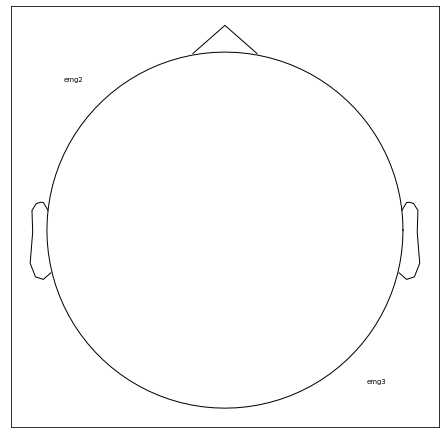

In [19]:
emg_montage = mne.channels.Montage(np.array([[0,0,10],[0,0,-10]]),ch_names = ['emg2','emg3'],kind = 'emg_test',selection = np.array([0,1]))
# raw_emg.set_montage(emg_montage)
layout_emg = mne.channels.Layout((-100,100,-100,100), np.array([[4,2,11,23],[1,1,20,20]]),names = ['emg2','emg3'],ids = [0,1],kind='emg_test')
layout_emg.plot()
biosemi_layout = mne.channels.read_layout('biosemi')


In [19]:
# Validation of data concatenation
%matplotlib qt
epochs_eeg_resampled.plot(picks = 'all')
epochs_eeg.plot_image()

Dropped 0 epochs
Channels marked as bad: []
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


[<Figure size 432x288 with 3 Axes>]

In [20]:
# Connectivity
from mne.connectivity import spectral_connectivity
epochs_hybrid = epochs_eeg_resampled.copy()
epochs_hybrid.load_data()
fmin = 2
fmax = 8
tmin = 0
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    epochs_hybrid, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 561 connections
    using t=0.000s..11.990s for estimation (1200 points)
    frequencies: 2.0Hz..8.0Hz (73 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivi

In [62]:
from mne.viz import plot_sensors_connectivity
plot_sensors_connectivity(epochs_hybrid.info, con[0:32, 0:32, 0])
#con[27:32,27:32,0]

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

[(0, 2, {'weight': 0.3828144458281445}), (1, 2, {'weight': 0.34595267745952685}), (2, 3, {'weight': 0.4993773349937734}), (2, 5, {'weight': 0.4246575342465753}), (4, 5, {'weight': 0.17758405977584063})]


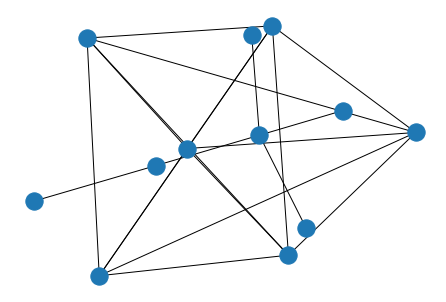

In [88]:
#Calculer MST
import networkx as nx
cntvt_graph = nx.Graph( con[1:7, 1:7, 0])
nx.draw(cntvt_graph)
mst_cntvt = nx.maximum_spanning_tree(cntvt_graph)
print(sorted(mst_cntvt.edges(data=True)))
nx.draw(mst_cntvt)
# cntvt_graph.adj

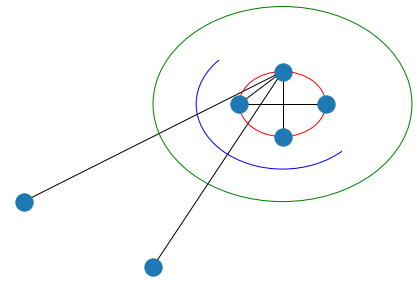

In [87]:
#2D location
%matplotlib inline
pos = [[2,0],[-1,2],[5,6],[5,4],[6,5],[4,5]]
import matplotlib.pyplot as plt

circle1 = plt.Circle((5, 5), 1, color='r',fill = False)
circle2 = plt.Circle((5, 5), 2, color='blue',fill = False)
circle3 = plt.Circle((5, 5), 3, color='g', clip_on=False, fill =False)



fig, ax = plt.subplots()
# note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
nx.draw(mst_cntvt,pos=pos)

plt.show()


In [ ]:
fig = plt.gcf()
ax = fig.gca
plt.figure()

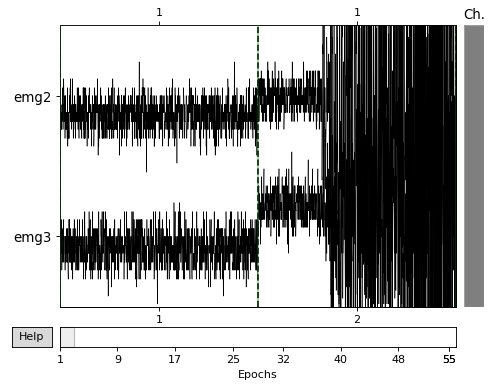

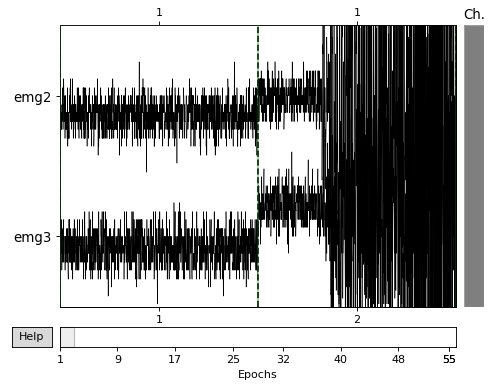

In [103]:
epochs_emg.plot(picks = ['emg'],n_epochs = 2)

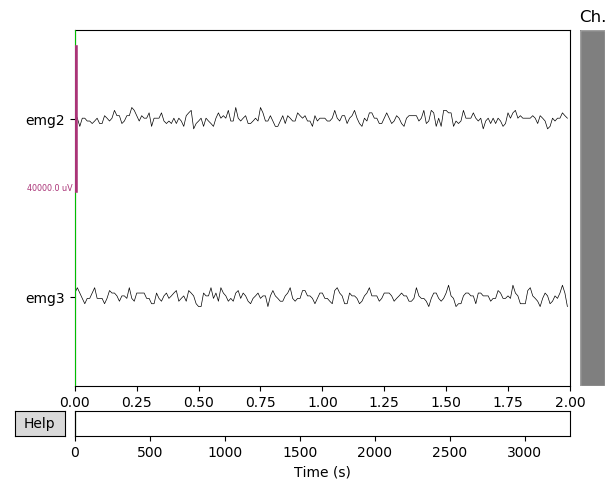

In [116]:
%matplotlib qt
raw.plot( scalings = 2e-2,duration =2)

## Next step - fusion two dataset and visualize 
    - read EMG into raw file - process - epochs
    - combine two epochs
    - iCOH calculation - visualization

In [69]:
0.09*0.3

0.027

In [45]:
def normalx(x):
    output = (x-4.214)/0.67
    print(output)
    return True
for x in np.linspace(2.65,5.65,11):
    normalx(x)


-2.334328358208956
-1.8865671641791046
-1.4388059701492542
-0.9910447761194038
-0.5432835820895527
-0.09552238805970158
0.3522388059701489
0.7999999999999994
1.2477611940298512
1.6955223880597003
2.143283582089552
